# Regression using Pytorch

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from source.ffnn_model import WellLogFFNN
from source.ffnn_well_data_preprocessing import load_log_data

# Reproducibility, gotten from project 2
NP_RANDOM_SEED = 42
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)


In [2]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)



[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Shapes:
X_train: torch.Size([8699, 11])
y_train: torch.Size([8699, 1])
X_val: torch.Size([1864, 11])
X_test: torch.Size([1865, 11])


In [3]:
# Basic statistics of y_train
print("y_train min:", y_train.min().item())
print("y_train max:", y_train.max().item())
print("y_train mean:", y_train.mean().item())
print("y_train std:", y_train.std().item())


y_train min: -5.2099175453186035
y_train max: 3.092235803604126
y_train mean: 1.973346153150146e-09
y_train std: 1.0000574588775635


In [4]:
"""

Defining model and training function.

The model is a feedforward neural network defined in source/ffnn_model.py.

The training function uses MSE loss and Adam optimizer.

Code is adapted from project 2 part c.

"""

input_dim = X_train.shape[1]

# Defining model
def make_model(hidden_dims=(64, 64), dropout=0.2, activation=nn.ReLU):
    return WellLogFFNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    )
# Training function
def train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr: float = 1e-3,
    epochs: int = 100,
    verbose: bool = False,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state_dict = None

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:4d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss:.4f}")

    # last best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, best_val_loss, train_losses, val_losses


In [5]:
# Training with different configurations and evaluating on test set
configs = [
    {"name": "small_no_dropout",  "hidden_dims": (32, 32),        "lr": 1e-3, "dropout": 0.0},
    {"name": "medium_dropout",    "hidden_dims": (64, 64),        "lr": 1e-3, "dropout": 0.2},
    {"name": "deep_dropout",      "hidden_dims": (128, 64, 32),   "lr": 1e-4, "dropout": 0.2},
    {"name": "medium_lr_high",    "hidden_dims": (64, 64),        "lr": 1e-2, "dropout": 0.2},
]

results = []
histories = {}

for cfg in configs:
    print(f"\n=== Training config: {cfg['name']} ===")
    print(f"hidden_dims={cfg['hidden_dims']}, lr={cfg['lr']}, dropout={cfg['dropout']}")

    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)

    model = make_model(
        hidden_dims=cfg["hidden_dims"],
        dropout=cfg["dropout"],
        activation=nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=cfg["lr"],
        epochs=100,
        verbose=False,
    )

    # evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_mse = nn.MSELoss()(y_pred_test, y_test).item()

    results.append({
        "name":        cfg["name"],
        "hidden_dims": cfg["hidden_dims"],
        "lr":          cfg["lr"],
        "dropout":     cfg["dropout"],
        "val_mse":     best_val_mse,
        "test_mse":    test_mse,
    })

    histories[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
    }

results_df = pd.DataFrame(results)
display(results_df)



=== Training config: small_no_dropout ===
hidden_dims=(32, 32), lr=0.001, dropout=0.0

=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2


,name,hidden_dims,lr,dropout,val_mse,test_mse
0,small_no_dropout,"(32, 32)",0.0010,0.0,0.291310,0.286603
1,medium_dropout,"(64, 64)",0.0010,0.2,0.253414,0.253128
2,deep_dropout,"(128, 64, 32)",0.0001,0.2,0.744351,0.715111
3,medium_lr_high,"(64, 64)",0.0100,0.2,0.178354,0.188774


In [6]:
import optuna
from optuna.trial import Trial  

"""Objective function for Optuna hyperparameter optimization."""

# Define objective function for Optuna
def objective(trial):
    data_seed = trial.suggest_int("data_seed", 0, 1_000_000)

    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(
        random_state=data_seed
    )    
    
    
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 16, 256, step=16)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 256, step=16)
    hidden_dim3 = trial.suggest_int("hidden_dim3", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # Build hidden_dims tuple based on n_layers
    hidden_dims_list = [hidden_dim1, hidden_dim2, hidden_dim3][:n_layers]
    hidden_dims = tuple(hidden_dims_list)
    
    # Reset seeds for reproducibility
    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)
    
    # Create and train model
    model = make_model(
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=nn.ReLU,
    )
    
    model, best_val_mse, _, _ = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        lr=lr,
        epochs=100,
        verbose=False,
    )
    
    return best_val_mse

# Create and run Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=NP_RANDOM_SEED),
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"Best validation MSE: {best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("="*60)


/workspaces/project3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-16 12:06:40,372] A new study created in memory with name: no-name-83d6b009-01b3-40e8-8949-2670e15ae0a7


Starting Optuna hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.761418:   2%|▏         | 1/50 [00:05<04:14,  5.19s/it]

[I 2025-12-16 12:06:45,560] Trial 0 finished with value: 0.7614184617996216 and parameters: {'data_seed': 374540, 'hidden_dim1': 256, 'hidden_dim2': 192, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.0, 'lr': 1.493656855461762e-05}. Best is trial 0 with value: 0.7614184617996216.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 1. Best value: 0.751465:   4%|▍         | 2/50 [00:14<06:07,  7.65s/it]

[I 2025-12-16 12:06:54,937] Trial 1 finished with value: 0.751465380191803 and parameters: {'data_seed': 866177, 'hidden_dim1': 160, 'hidden_dim2': 192, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.4, 'lr': 4.335281794951564e-05}. Best is trial 1 with value: 0.751465380191803.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.256032:   6%|▌         | 3/50 [00:20<05:16,  6.73s/it]

[I 2025-12-16 12:07:00,570] Trial 2 finished with value: 0.25603190064430237 and parameters: {'data_seed': 181825, 'hidden_dim1': 48, 'hidden_dim2': 80, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.000684792009557478}. Best is trial 2 with value: 0.25603190064430237.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.237896:   8%|▊         | 4/50 [00:26<04:59,  6.51s/it]

[I 2025-12-16 12:07:06,741] Trial 3 finished with value: 0.23789574205875397 and parameters: {'data_seed': 139494, 'hidden_dim1': 80, 'hidden_dim2': 96, 'hidden_dim3': 128, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0003489018845491386}. Best is trial 3 with value: 0.23789574205875397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.237896:  10%|█         | 5/50 [00:30<04:19,  5.77s/it]

[I 2025-12-16 12:07:11,207] Trial 4 finished with value: 0.35145366191864014 and parameters: {'data_seed': 592415, 'hidden_dim1': 16, 'hidden_dim2': 160, 'hidden_dim3': 48, 'n_layers': 2, 'dropout': 0.5, 'lr': 0.00788671412999049}. Best is trial 3 with value: 0.23789574205875397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.237896:  12%|█▏        | 6/50 [00:33<03:21,  4.59s/it]

[I 2025-12-16 12:07:13,496] Trial 5 finished with value: 0.27606359124183655 and parameters: {'data_seed': 808398, 'hidden_dim1': 80, 'hidden_dim2': 32, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0003058656666978527}. Best is trial 3 with value: 0.23789574205875397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.237896:  14%|█▍        | 7/50 [00:40<03:49,  5.34s/it]

[I 2025-12-16 12:07:20,377] Trial 6 finished with value: 0.2673363983631134 and parameters: {'data_seed': 34388, 'hidden_dim1': 240, 'hidden_dim2': 80, 'hidden_dim3': 176, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.00043664735929796326}. Best is trial 3 with value: 0.23789574205875397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 7. Best value: 0.178975:  16%|█▌        | 8/50 [00:56<06:15,  8.94s/it]

[I 2025-12-16 12:07:37,030] Trial 7 finished with value: 0.17897452414035797 and parameters: {'data_seed': 184854, 'hidden_dim1': 256, 'hidden_dim2': 208, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.00582938454299474}. Best is trial 7 with value: 0.17897452414035797.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 7. Best value: 0.178975:  18%|█▊        | 9/50 [00:59<04:50,  7.09s/it]

[I 2025-12-16 12:07:40,055] Trial 8 finished with value: 0.1927204430103302 and parameters: {'data_seed': 88492, 'hidden_dim1': 64, 'hidden_dim2': 16, 'hidden_dim3': 96, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.003063462210622081}. Best is trial 7 with value: 0.17897452414035797.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.155343:  20%|██        | 10/50 [01:01<03:41,  5.53s/it]

[I 2025-12-16 12:07:42,093] Trial 9 finished with value: 0.15534283220767975 and parameters: {'data_seed': 356753, 'hidden_dim1': 80, 'hidden_dim2': 144, 'hidden_dim3': 48, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.009133995846860976}. Best is trial 9 with value: 0.15534283220767975.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.155343:  22%|██▏       | 11/50 [01:11<04:24,  6.78s/it]

[I 2025-12-16 12:07:51,702] Trial 10 finished with value: 0.16018688678741455 and parameters: {'data_seed': 471357, 'hidden_dim1': 144, 'hidden_dim2': 256, 'hidden_dim3': 64, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0015527469527538585}. Best is trial 9 with value: 0.15534283220767975.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.155343:  24%|██▍       | 12/50 [01:20<04:48,  7.59s/it]

[I 2025-12-16 12:08:01,163] Trial 11 finished with value: 0.17815664410591125 and parameters: {'data_seed': 450300, 'hidden_dim1': 144, 'hidden_dim2': 256, 'hidden_dim3': 64, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0014724517030801226}. Best is trial 9 with value: 0.15534283220767975.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.155343:  26%|██▌       | 13/50 [01:29<04:51,  7.89s/it]

[I 2025-12-16 12:08:09,736] Trial 12 finished with value: 0.1645946353673935 and parameters: {'data_seed': 621744, 'hidden_dim1': 176, 'hidden_dim2': 256, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0023681433985632936}. Best is trial 9 with value: 0.15534283220767975.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.155343:  28%|██▊       | 14/50 [01:31<03:45,  6.25s/it]

[I 2025-12-16 12:08:12,199] Trial 13 finished with value: 0.16461290419101715 and parameters: {'data_seed': 325142, 'hidden_dim1': 112, 'hidden_dim2': 128, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.009728583151931078}. Best is trial 9 with value: 0.15534283220767975.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.155343:  30%|███       | 15/50 [01:42<04:21,  7.46s/it]

[I 2025-12-16 12:08:22,456] Trial 14 finished with value: 0.19022944569587708 and parameters: {'data_seed': 653500, 'hidden_dim1': 192, 'hidden_dim2': 224, 'hidden_dim3': 112, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0011606159532098611}. Best is trial 9 with value: 0.15534283220767975.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.155343:  32%|███▏      | 16/50 [01:48<04:06,  7.25s/it]

[I 2025-12-16 12:08:29,234] Trial 15 finished with value: 0.4823131561279297 and parameters: {'data_seed': 310037, 'hidden_dim1': 128, 'hidden_dim2': 144, 'hidden_dim3': 48, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.00010009228282781822}. Best is trial 9 with value: 0.15534283220767975.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.145618:  34%|███▍      | 17/50 [01:58<04:18,  7.84s/it]

[I 2025-12-16 12:08:38,425] Trial 16 finished with value: 0.14561809599399567 and parameters: {'data_seed': 501334, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.003875012926226521}. Best is trial 16 with value: 0.14561809599399567.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  36%|███▌      | 18/50 [02:07<04:23,  8.23s/it] 

[I 2025-12-16 12:08:47,562] Trial 17 finished with value: 0.13547973334789276 and parameters: {'data_seed': 781039, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.004006330380285949}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  38%|███▊      | 19/50 [02:16<04:26,  8.60s/it]

[I 2025-12-16 12:08:57,019] Trial 18 finished with value: 0.14938898384571075 and parameters: {'data_seed': 981299, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.00356613387089589}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  40%|████      | 20/50 [02:23<04:05,  8.18s/it]

[I 2025-12-16 12:09:04,237] Trial 19 finished with value: 0.4420155882835388 and parameters: {'data_seed': 766126, 'hidden_dim1': 224, 'hidden_dim2': 48, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 9.141536671284846e-05}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  42%|████▏     | 21/50 [02:33<04:05,  8.47s/it]

[I 2025-12-16 12:09:13,389] Trial 20 finished with value: 0.17879778146743774 and parameters: {'data_seed': 997155, 'hidden_dim1': 208, 'hidden_dim2': 64, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.004158594255145974}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  44%|████▍     | 22/50 [02:43<04:12,  9.03s/it]

[I 2025-12-16 12:09:23,717] Trial 21 finished with value: 0.15234754979610443 and parameters: {'data_seed': 980728, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0036598849908878956}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  46%|████▌     | 23/50 [02:53<04:08,  9.22s/it]

[I 2025-12-16 12:09:33,384] Trial 22 finished with value: 0.17803826928138733 and parameters: {'data_seed': 899183, 'hidden_dim1': 176, 'hidden_dim2': 112, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0008674579603417143}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  48%|████▊     | 24/50 [02:58<03:30,  8.10s/it]

[I 2025-12-16 12:09:38,880] Trial 23 finished with value: 0.1623438000679016 and parameters: {'data_seed': 714350, 'hidden_dim1': 224, 'hidden_dim2': 160, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0021714061900504193}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  50%|█████     | 25/50 [03:08<03:39,  8.77s/it]

[I 2025-12-16 12:09:49,204] Trial 24 finished with value: 0.14991305768489838 and parameters: {'data_seed': 923322, 'hidden_dim1': 192, 'hidden_dim2': 112, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.004584407322636679}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  52%|█████▏    | 26/50 [03:16<03:23,  8.49s/it]

[I 2025-12-16 12:09:57,027] Trial 25 finished with value: 0.16184033453464508 and parameters: {'data_seed': 535281, 'hidden_dim1': 224, 'hidden_dim2': 80, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.002117048628870219}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  54%|█████▍    | 27/50 [03:25<03:19,  8.68s/it]

[I 2025-12-16 12:10:06,159] Trial 26 finished with value: 0.26204076409339905 and parameters: {'data_seed': 818072, 'hidden_dim1': 176, 'hidden_dim2': 128, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.00016878548722629164}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  56%|█████▌    | 28/50 [03:38<03:38,  9.95s/it]

[I 2025-12-16 12:10:19,082] Trial 27 finished with value: 0.19277241826057434 and parameters: {'data_seed': 713677, 'hidden_dim1': 240, 'hidden_dim2': 160, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0006531274860109067}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  58%|█████▊    | 29/50 [03:42<02:47,  7.98s/it]

[I 2025-12-16 12:10:22,446] Trial 28 finished with value: 0.1360325962305069 and parameters: {'data_seed': 542601, 'hidden_dim1': 208, 'hidden_dim2': 96, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0060341763783318715}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  60%|██████    | 30/50 [03:43<02:03,  6.16s/it]

[I 2025-12-16 12:10:24,358] Trial 29 finished with value: 0.15752792358398438 and parameters: {'data_seed': 500857, 'hidden_dim1': 256, 'hidden_dim2': 48, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.005961827462333599}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  62%|██████▏   | 31/50 [03:47<01:43,  5.44s/it]

[I 2025-12-16 12:10:28,132] Trial 30 finished with value: 0.9935420751571655 and parameters: {'data_seed': 412876, 'hidden_dim1': 112, 'hidden_dim2': 176, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.0, 'lr': 1.1641609056119206e-05}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  64%|██████▍   | 32/50 [03:51<01:27,  4.86s/it]

[I 2025-12-16 12:10:31,647] Trial 31 finished with value: 0.14505872130393982 and parameters: {'data_seed': 583378, 'hidden_dim1': 208, 'hidden_dim2': 96, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0035331532151353035}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  66%|██████▌   | 33/50 [03:54<01:15,  4.47s/it]

[I 2025-12-16 12:10:35,180] Trial 32 finished with value: 0.14801236987113953 and parameters: {'data_seed': 595277, 'hidden_dim1': 192, 'hidden_dim2': 96, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006215259325765182}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  68%|██████▊   | 34/50 [03:58<01:05,  4.09s/it]

[I 2025-12-16 12:10:38,402] Trial 33 finished with value: 0.8355509638786316 and parameters: {'data_seed': 554146, 'hidden_dim1': 160, 'hidden_dim2': 96, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.0, 'lr': 2.5284327931762614e-05}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  70%|███████   | 35/50 [04:01<00:56,  3.77s/it]

[I 2025-12-16 12:10:41,432] Trial 34 finished with value: 0.15400590002536774 and parameters: {'data_seed': 264857, 'hidden_dim1': 240, 'hidden_dim2': 64, 'hidden_dim3': 144, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0025106777764723133}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  72%|███████▏  | 36/50 [04:08<01:07,  4.84s/it]

[I 2025-12-16 12:10:48,752] Trial 35 finished with value: 0.17607980966567993 and parameters: {'data_seed': 679651, 'hidden_dim1': 160, 'hidden_dim2': 80, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0014726939568461283}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 17. Best value: 0.13548:  74%|███████▍  | 37/50 [04:12<00:58,  4.52s/it]

[I 2025-12-16 12:10:52,537] Trial 36 finished with value: 0.14081767201423645 and parameters: {'data_seed': 396080, 'hidden_dim1': 208, 'hidden_dim2': 128, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006092137603037313}. Best is trial 17 with value: 0.13547973334789276.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  76%|███████▌  | 38/50 [04:15<00:51,  4.27s/it]

[I 2025-12-16 12:10:56,223] Trial 37 finished with value: 0.12872901558876038 and parameters: {'data_seed': 415257, 'hidden_dim1': 224, 'hidden_dim2': 128, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006893981666219509}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  78%|███████▊  | 39/50 [04:19<00:44,  4.07s/it]

[I 2025-12-16 12:10:59,819] Trial 38 finished with value: 0.15862038731575012 and parameters: {'data_seed': 242502, 'hidden_dim1': 256, 'hidden_dim2': 176, 'hidden_dim3': 128, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.006489424984566505}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  80%|████████  | 40/50 [04:21<00:35,  3.53s/it]

[I 2025-12-16 12:11:02,084] Trial 39 finished with value: 0.16512897610664368 and parameters: {'data_seed': 396908, 'hidden_dim1': 16, 'hidden_dim2': 128, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.009559829465754493}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  82%|████████▏ | 41/50 [04:34<00:55,  6.17s/it]

[I 2025-12-16 12:11:14,435] Trial 40 finished with value: 0.17770257592201233 and parameters: {'data_seed': 239733, 'hidden_dim1': 240, 'hidden_dim2': 144, 'hidden_dim3': 144, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.005228356962177064}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  84%|████████▍ | 42/50 [04:37<00:42,  5.33s/it]

[I 2025-12-16 12:11:17,780] Trial 41 finished with value: 0.14351537823677063 and parameters: {'data_seed': 453551, 'hidden_dim1': 224, 'hidden_dim2': 96, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.007626630824429318}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  86%|████████▌ | 43/50 [04:40<00:32,  4.61s/it]

[I 2025-12-16 12:11:20,736] Trial 42 finished with value: 0.1470056176185608 and parameters: {'data_seed': 446099, 'hidden_dim1': 224, 'hidden_dim2': 64, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.007196964478970395}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  88%|████████▊ | 44/50 [04:44<00:25,  4.33s/it]

[I 2025-12-16 12:11:24,409] Trial 43 finished with value: 0.13575492799282074 and parameters: {'data_seed': 360186, 'hidden_dim1': 192, 'hidden_dim2': 128, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.00745743685710114}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  90%|█████████ | 45/50 [04:47<00:20,  4.17s/it]

[I 2025-12-16 12:11:28,185] Trial 44 finished with value: 0.13947853446006775 and parameters: {'data_seed': 360321, 'hidden_dim1': 192, 'hidden_dim2': 128, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0027589926432784947}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  92%|█████████▏| 46/50 [04:57<00:22,  5.69s/it]

[I 2025-12-16 12:11:37,433] Trial 45 finished with value: 0.15618418157100677 and parameters: {'data_seed': 169516, 'hidden_dim1': 192, 'hidden_dim2': 144, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.002536671621627811}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  94%|█████████▍| 47/50 [05:01<00:16,  5.42s/it]

[I 2025-12-16 12:11:42,230] Trial 46 finished with value: 0.1746056228876114 and parameters: {'data_seed': 351926, 'hidden_dim1': 176, 'hidden_dim2': 160, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0017282631893307105}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  96%|█████████▌| 48/50 [05:09<00:12,  6.05s/it]

[I 2025-12-16 12:11:49,738] Trial 47 finished with value: 0.19243206083774567 and parameters: {'data_seed': 295956, 'hidden_dim1': 192, 'hidden_dim2': 128, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0010456535498428552}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729:  98%|█████████▊| 49/50 [05:19<00:07,  7.37s/it]

[I 2025-12-16 12:12:00,204] Trial 48 finished with value: 0.17422831058502197 and parameters: {'data_seed': 17762, 'hidden_dim1': 144, 'hidden_dim2': 176, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.009825123906848985}. Best is trial 37 with value: 0.12872901558876038.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.128729: 100%|██████████| 50/50 [05:25<00:00,  6.50s/it]

[I 2025-12-16 12:12:05,597] Trial 49 finished with value: 0.15191233158111572 and parameters: {'data_seed': 126323, 'hidden_dim1': 160, 'hidden_dim2': 192, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.004742612698711907}. Best is trial 37 with value: 0.12872901558876038.

OPTUNA OPTIMIZATION RESULTS
Best validation MSE: 0.128729

Best hyperparameters:
  data_seed: 415257
  hidden_dim1: 224
  hidden_dim2: 128
  hidden_dim3: 160
  n_layers: 4
  dropout: 0.0
  lr: 0.006893981666219509


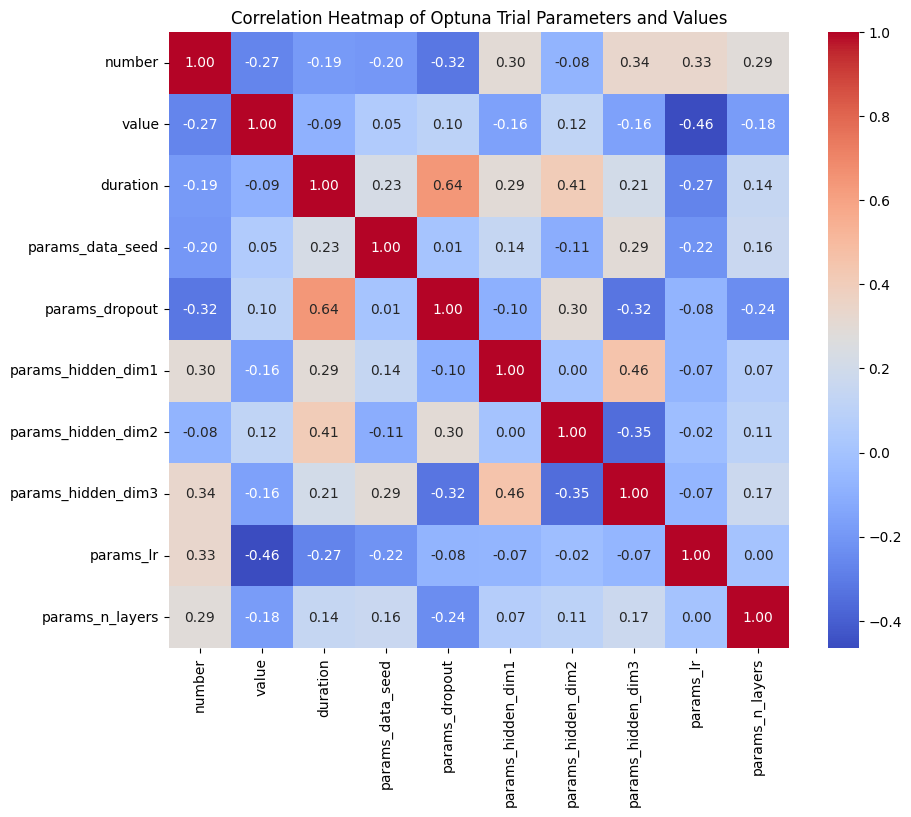

In [7]:
#plotting a heatmap of the optuna results
import seaborn as sns
import matplotlib.pyplot as plt

optuna_df = study.trials_dataframe()
plt.figure(figsize=(10, 8))
sns.heatmap(optuna_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Optuna Trial Parameters and Values")
plt.show()

In [8]:
# === Extract best hyperparameters from Optuna ===
best_params = best_trial.params

# Build hidden layers tuple
n_layers = best_params["n_layers"]
best_hidden_dims = tuple([
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["hidden_dim3"],
][:n_layers])

best_dropout = best_params["dropout"]
best_lr = best_params["lr"]

print("Using hidden_dims =", best_hidden_dims)
print("dropout =", best_dropout)
print("learning rate =", best_lr)


Using hidden_dims = (224, 128, 160)
dropout = 0.0
learning rate = 0.006893981666219509


Best config: medium_lr_high


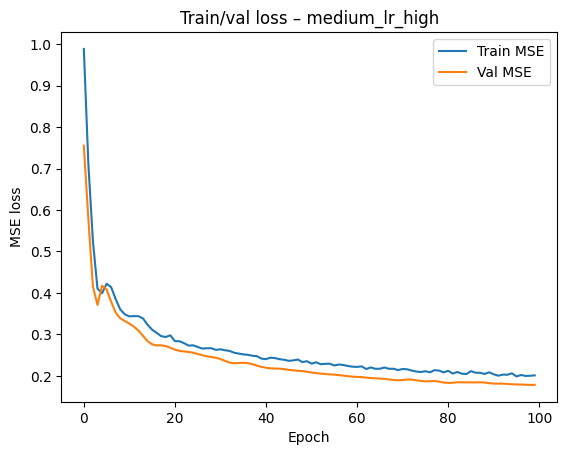

In [9]:
import matplotlib.pyplot as plt

y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled      = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting train/val loss curves for best config
best_name = results_df.sort_values("val_mse").iloc[0]["name"]
print("Best config:", best_name)

train_losses = histories[best_name]["train_losses"]
val_losses   = histories[best_name]["val_losses"]

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Train/val loss – {best_name}")
plt.show()


Best Optuna params: {'data_seed': 415257, 'hidden_dim1': 224, 'hidden_dim2': 128, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006893981666219509}
Using hidden_dims = (224, 128, 160) dropout = 0.0 lr = 0.006893981666219509


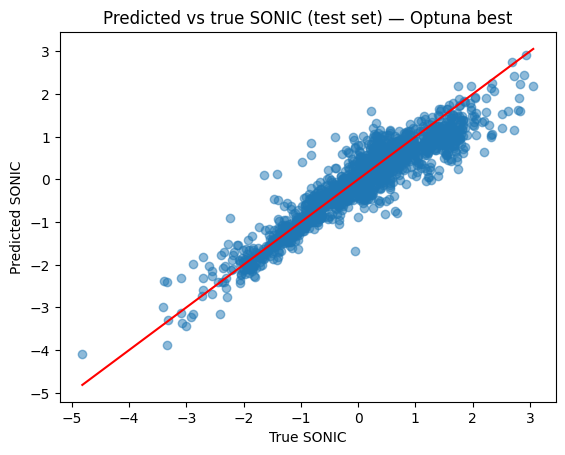

In [10]:
# Use Optuna best trial to rebuild & retrain the model, then plot preds vs true
params = best_trial.params
n_layers = params.get("n_layers", 2)
hidden_dims = tuple([params["hidden_dim1"], params["hidden_dim2"], params["hidden_dim3"]][:n_layers])
dropout = params.get("dropout", 0.0)
lr = params.get("lr", 1e-3)

print("Best Optuna params:", params)
print("Using hidden_dims =", hidden_dims, "dropout =", dropout, "lr =", lr)

# Reproducibility
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)

# Build and train model using Optuna params
model = make_model(
    hidden_dims=hidden_dims,
    dropout=dropout,
    activation=nn.ReLU,
)
model, _, _, _ = train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr=lr,
    epochs=100,
    verbose=False,
)

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()
y_true_test = y_test.cpu().numpy()

# Scatter plot
plt.figure()
plt.scatter(y_true_test, y_pred_test, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Optuna best")
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color="red")
plt.show()


[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 0: R² = 0.8282
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 1: R² = 0.8441
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 2: R² = 0.8584
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 3: R² = 0.8594
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 4: R² = 0.7998


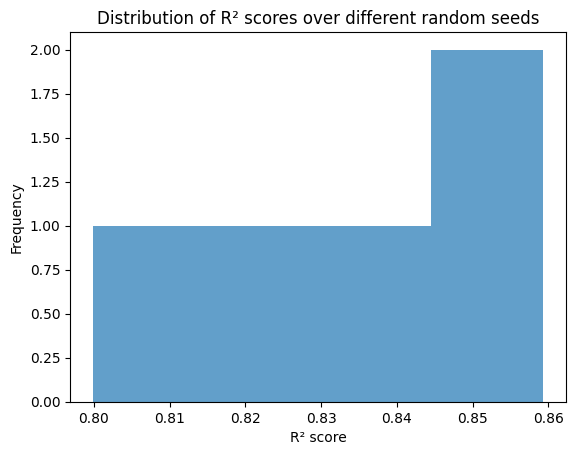

In [11]:
"""
Calculating R² score.
"""

from sklearn.metrics import r2_score

seeds = [0, 1, 2, 3, 4]
scores = []

for seed in seeds:
    # 1. new random split
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

    # 2. train model with same hyperparameters
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = make_model(  # use best params fra Optuna
        hidden_dims = hidden_dims,
        dropout = best_dropout,
        activation = nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=best_lr,
        epochs=100,
        verbose=False,
    )

    # 3. evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)

    r2 = r2_score(
        y_test.numpy().ravel(),
        y_pred_test.numpy().ravel()
    )
    print(f"Seed {seed}: R² = {r2:.4f}")
    scores.append(r2)

print("R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std  R²:", np.std(scores))

plt.figure()
plt.hist(scores, bins='auto', alpha=0.7)
plt.xlabel("R² score")
plt.ylabel("Frequency")
plt.title("Distribution of R² scores over different random seeds")
plt.show()



Ridge baseline:
Test MSE: 0.3844129741191864
Test R²: 0.620905339717865


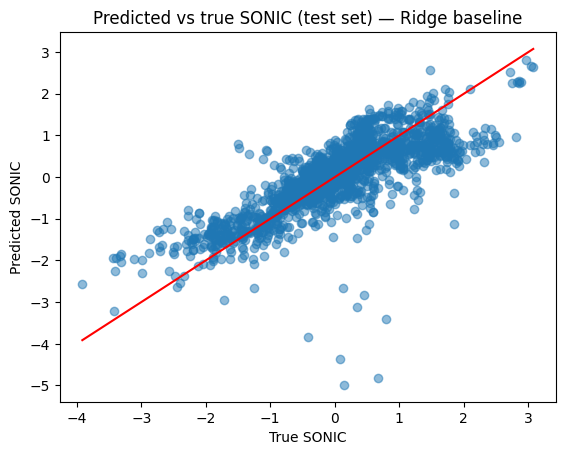

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Convert tensors to numpy
X_tr = X_train.numpy()
y_tr = y_train.numpy().ravel()
X_te = X_test.numpy()
y_te = y_test.numpy().ravel()

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

ridge_pred = ridge.predict(X_te)

ridge_mse = mean_squared_error(y_te, ridge_pred)
ridge_r2  = r2_score(y_te, ridge_pred)

print("Ridge baseline:")
print("Test MSE:", ridge_mse)
print("Test R²:", ridge_r2)

plt.figure()
plt.scatter(y_te, ridge_pred, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Ridge baseline")
plt.plot([y_te.min(), y_te.max()],
            [y_te.min(), y_te.max()], color="red")
plt.show()
